# Texture Synthesis Using CNN in Pytorch

Check out the paper for implementation:

https://proceedings.neurips.cc/paper/2015/file/a5e00132373a7031000fd987a3c9f87b-Paper.pdf

In [ ]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Output

* Left: Original Image
* Mid: Style Image
* Right: Combined Image

Output: MonaLia and Starry Night



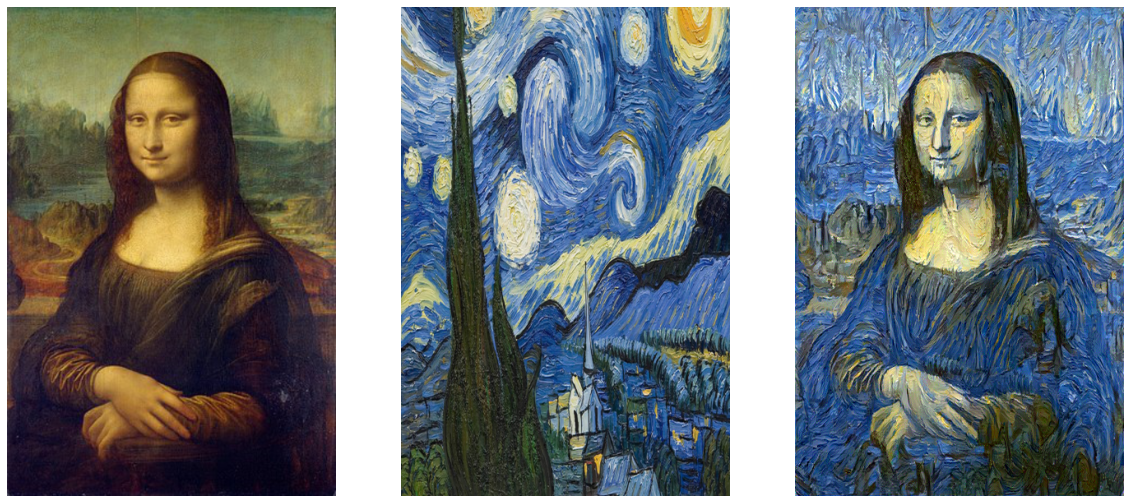

Experiment 1: My family with Van Gogh's Starry Night!

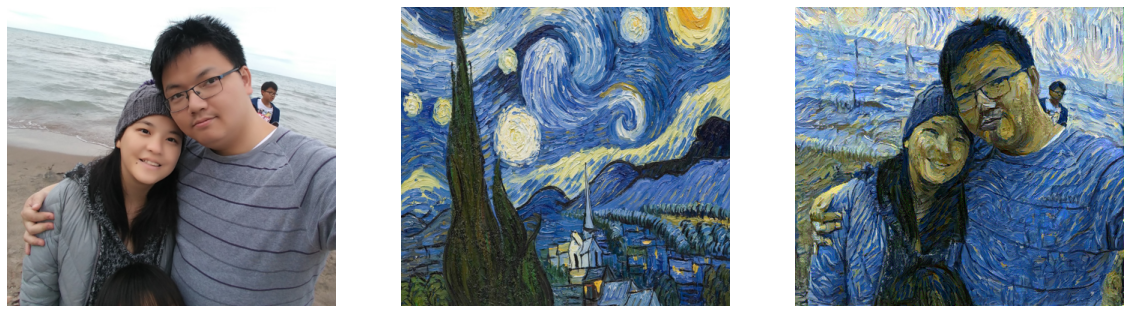

Experiment 2: My family with Galaxy style!

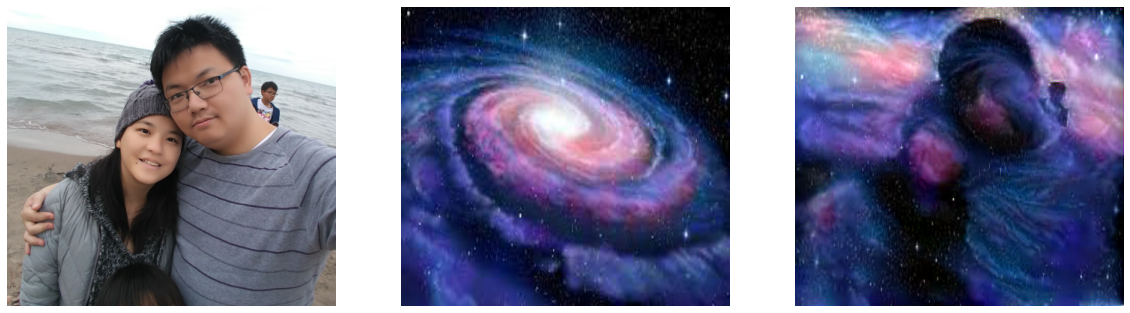

Experiment 3: Cannot really recognize us but it's fun!

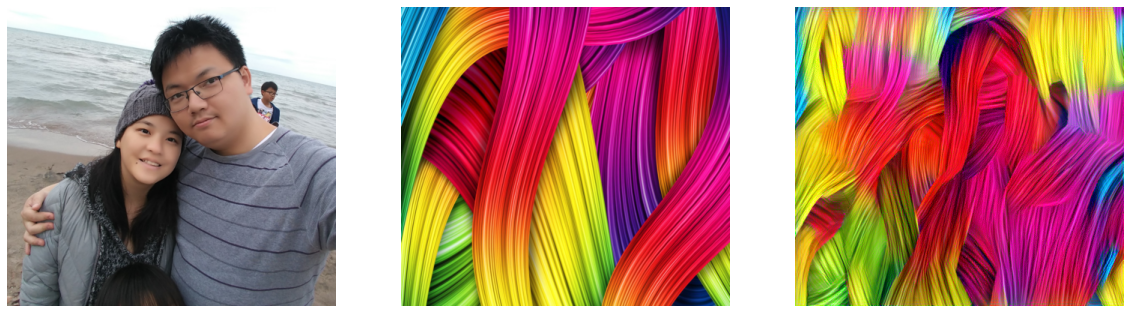

In [ ]:
# Implementation is done by vgg19
vgg = models.vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# Use pre-trained model only to save time
for param in vgg.parameters():
  param.requires_grad_(False)

In [ ]:
# Use cuda (Nvidia GPU only) if avaialable otherwise CPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pass the model to the GPU/CPU and display the model design
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# Create a function to load image. Note the size of the image is capped
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert("RGB")
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  if shape is not None:
    size = shape

  in_transform = transforms.Compose([
                                     transforms.Resize(size),
                                     transforms.ToTensor(), 
                                     transforms.Normalize((0.5, 0.5, 0.5), 
                                                          (0.5, 0.5, 0.5))])
  image = in_transform(image).unsqueeze(0)
  
  return image

## Your turn to try!

Upload your images to colab and change the file path and run-after!

Remember to use GPU otherwise it will take a very long time.

In [ ]:
# Loading content and style picture
content = load_image("MonaLisa.jpg").to(device)
style = load_image("StarryNight.jpg", shape=content.shape[-2:]).to(device)

In [ ]:
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0,1)
  return image

(-0.5, 399.5, 595.5, -0.5)

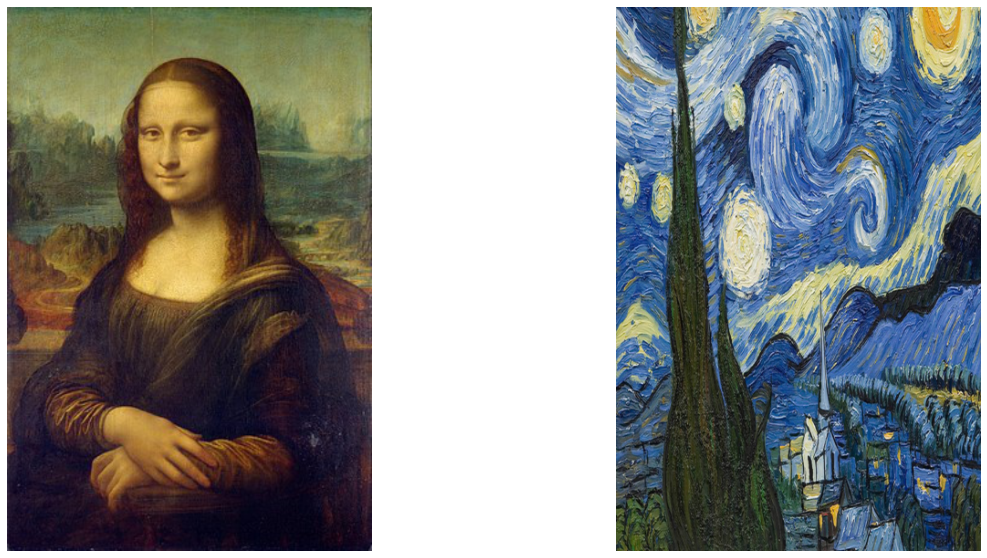

In [ ]:
# Show the Original Image and Content Image
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis("off")

In [ ]:
# Get the features by using the convolution
def get_features(image, model):
  layers = {"0": "conv1_1",
            "5": "conv2_1",
            "10": "conv3_1",
            "19": "conv4_1",
            "21": "conv4_2",
            "28": "conv5_1"}
  features = {}
  for name, layer in model._modules.items():
    image = layer(image)
    if name in layers:
      features[layers[name]] = image
  return features

In [ ]:
# Get content and style features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [ ]:
# Use gram matrix
def gram_matrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(d, h * w)
  gram = torch.mm(tensor, tensor.t())
  return gram

In [ ]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [ ]:
# Weights for the implementation
weights = [1.0, 0.75, 0.2 ,0.2 ,0.2]
style_weights = {"conv1_1": weights[0],
                 "conv2_1": weights[1],
                 "conv3_1": weights[2],
                 "conv4_1": weights[3],
                 "conv5_1": weights[4]}

content_weight = 1
style_weight = 1e6

In [ ]:
target = content.clone().requires_grad_(True).to(device)

In [ ]:
# Define parameters for the model
show_freq = 1000
optimizer = optim.Adam([target], lr = 0.001)
steps = 20000

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps / 300
counter = 0

Total loss:  2596530.25
Iteration:  1000


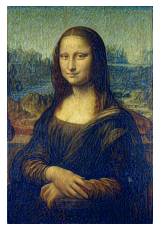

Total loss:  668477.3125
Iteration:  2000


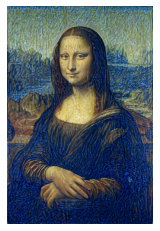

Total loss:  356902.78125
Iteration:  3000


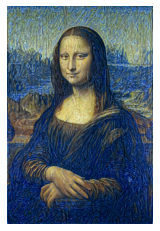

Total loss:  199233.890625
Iteration:  4000


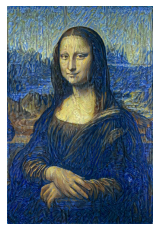

Total loss:  107734.0859375
Iteration:  5000


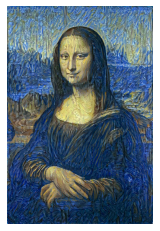

Total loss:  57050.2421875
Iteration:  6000


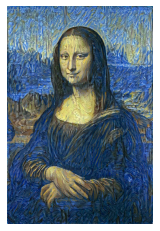

Total loss:  32041.03125
Iteration:  7000


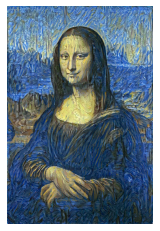

Total loss:  20586.08984375
Iteration:  8000


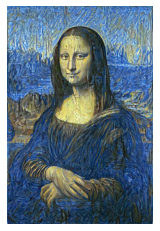

Total loss:  15015.9853515625
Iteration:  9000


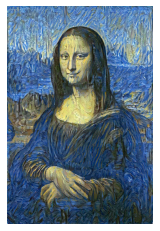

Total loss:  11979.8037109375
Iteration:  10000


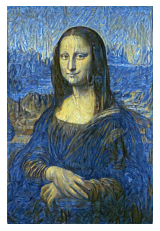

Total loss:  10122.7998046875
Iteration:  11000


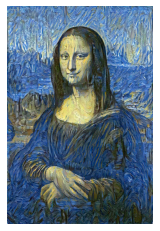

Total loss:  9002.04296875
Iteration:  12000


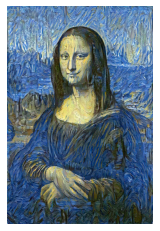

Total loss:  8262.5390625
Iteration:  13000


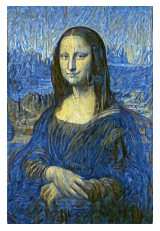

Total loss:  7781.97607421875
Iteration:  14000


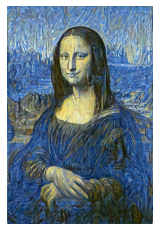

Total loss:  7520.98583984375
Iteration:  15000


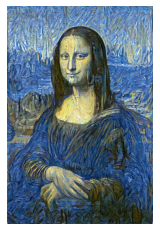

Total loss:  7147.884765625
Iteration:  16000


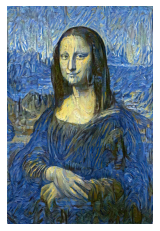

Total loss:  6924.86865234375
Iteration:  17000


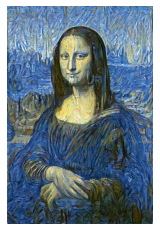

Total loss:  6733.48828125
Iteration:  18000


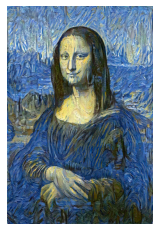

Total loss:  6584.74072265625
Iteration:  19000


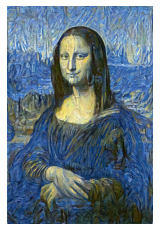

Total loss:  6438.19189453125
Iteration:  20000


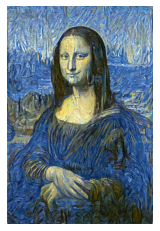

In [ ]:
# Run the model and you can see the outputs per show_freq defined above
for ii in range(1, steps + 1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"]) ** 2)
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)

  total_loss = content_loss * content_weight + style_loss * style_weight
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if ii % show_freq == 0 :
    print("Total loss: ", total_loss.item())
    print("Iteration: ", ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()

  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1


(-0.5, 399.5, 595.5, -0.5)

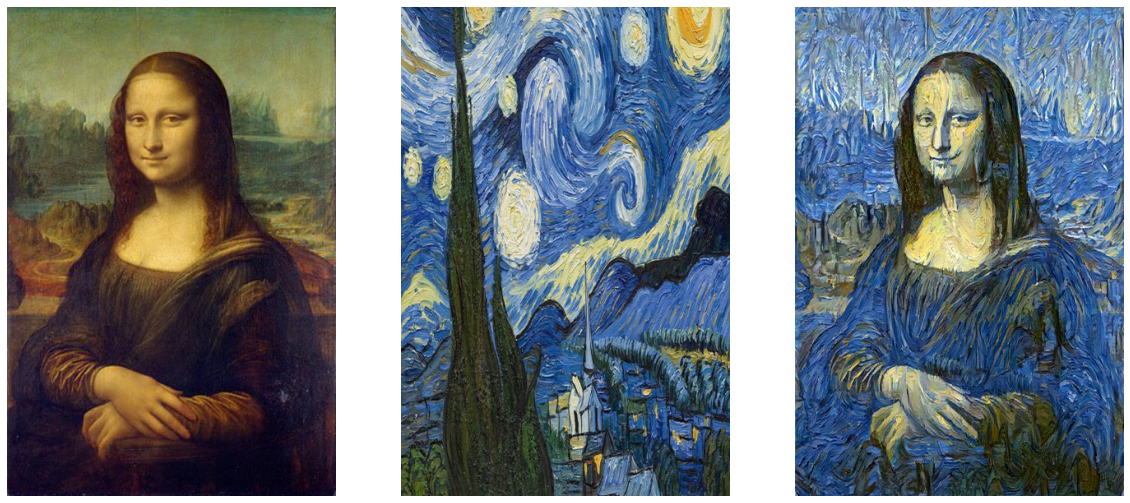

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")
ax3.imshow(im_convert(target))
ax3.axis("off")